# 1. Carregar Dados

In [35]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Carregando os arquivos
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')
df_submission = pd.read_csv('../data/sample_submission.csv')

print("Train shape:", df_train.shape)
print("\nPrimeiras linhas do conjunto de treino:")
print(df_train.head())

Train shape: (188533, 13)

Primeiras linhas do conjunto de treino:
   id          brand              model  model_year  milage      fuel_type  \
0   0           MINI      Cooper S Base        2007  213000       Gasoline   
1   1        Lincoln              LS V8        2002  143250       Gasoline   
2   2      Chevrolet  Silverado 2500 LT        2002  136731  E85 Flex Fuel   
3   3        Genesis   G90 5.0 Ultimate        2017   19500       Gasoline   
4   4  Mercedes-Benz        Metris Base        2021    7388       Gasoline   

                                              engine  \
0       172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel   
1       252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel   
2  320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...   
3       420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel   
4       208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel   

                     transmission ext_col int_col  \
0                             A/T  Yellow    Gray   
1                    

# 2. Análise Exploratória de Dados (EDA)
### Verificar missing, stats, correlations, uniques.

In [34]:
# Missing values
print(df_train.isna().sum())

# Stats
print(df_train.describe())

# Correlation (numéricas)
numeric = df_train.select_dtypes(include=[np.number])
corr = numeric.corr()['price'].sort_values()
print(corr)

# Uniques para categóricas
cat_cols = ['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']
for col in cat_cols:
    print(col, df_train[col].nunique())
    print(df_train[col].value_counts().head(5))

id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64
                  id     model_year         milage         price
count  188533.000000  188533.000000  188533.000000  1.885330e+05
mean    94266.000000    2015.829998   65705.295174  4.387802e+04
std     54424.933488       5.660967   49798.158076  7.881952e+04
min         0.000000    1974.000000     100.000000  2.000000e+03
25%     47133.000000    2013.000000   24115.000000  1.700000e+04
50%     94266.000000    2017.000000   57785.000000  3.082500e+04
75%    141399.000000    2020.000000   95400.000000  4.990000e+04
max    188532.000000    2024.000000  405000.000000  2.954083e+06
milage       -0.283067
id           -0.000877
model_year    0.231795
price         1.000000
Name: price, dtype: floa

### Gráficos:

Estilo 'seaborn' não disponível. Usando estilo 'ggplot' como alternativa.
Dados carregados com sucesso:
Shape de df_train: (188533, 13)
Shape de df_test: (125690, 12)
Shape de df_submission: (125690, 2)
Dados carregados com sucesso:
Shape de df_train: (188533, 13)
Shape de df_test: (125690, 12)
Shape de df_submission: (125690, 2)


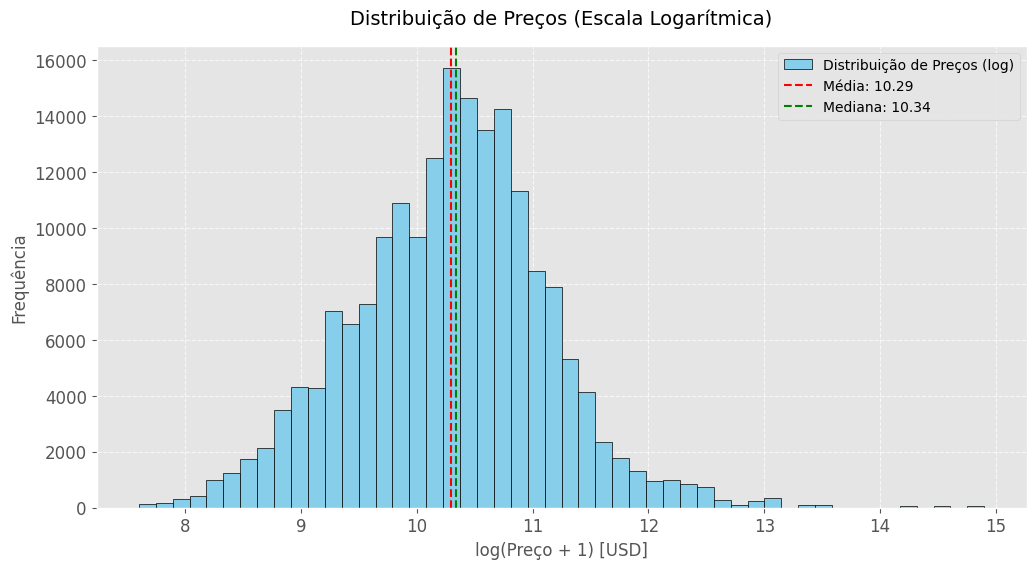

Observação: Distribuição skewed à direita, justificada a transformação logarítmica. Média: 29,488.44 USD, Mediana: 30,825.00 USD


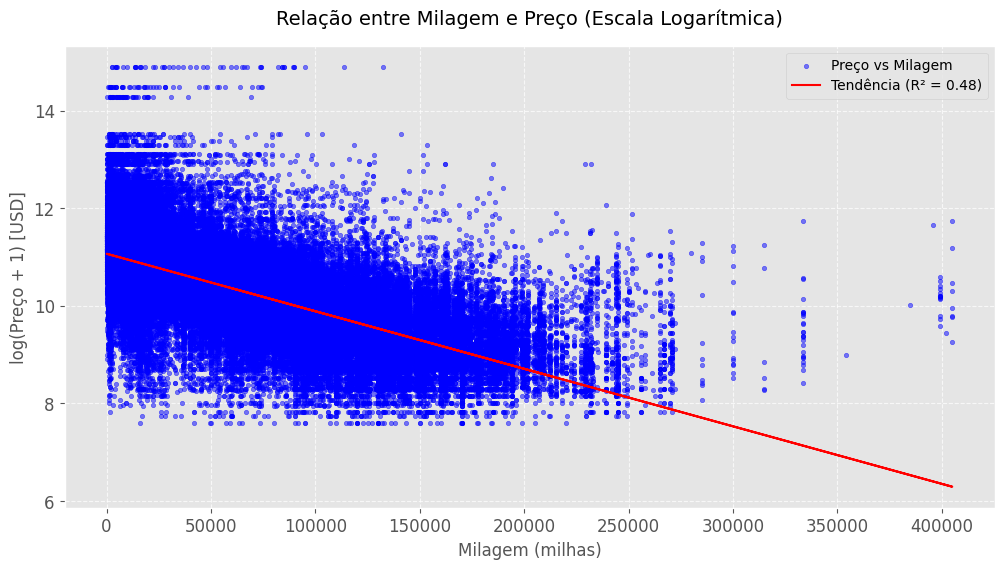

Observação: Correlação negativa entre milagem e preço (R² = 0.48), consistente com expectativa.


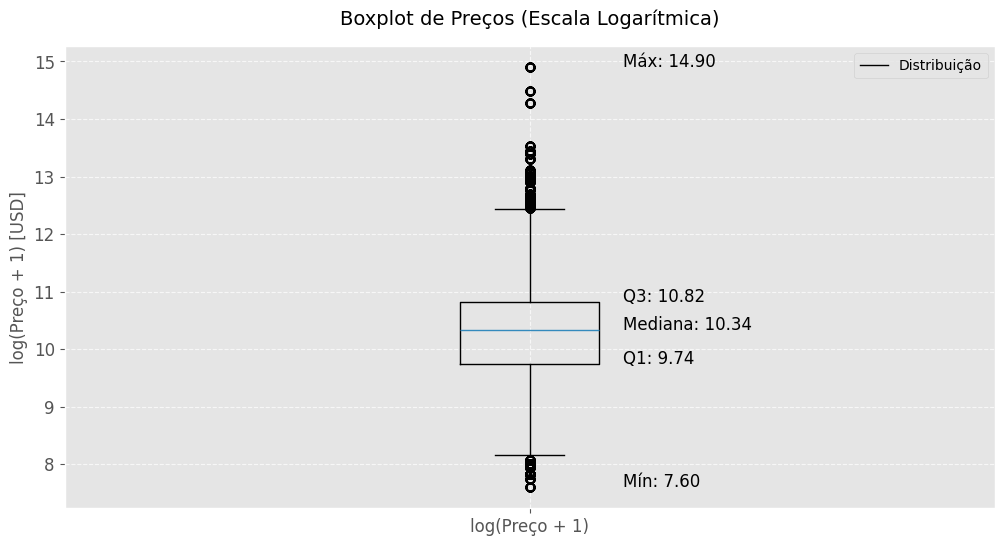

Observação: Presença de outliers significativos, justificada a transformação logarítmica para modelagem.


In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import FuncFormatter

# Tentar carregar estilo seaborn, com fallback para ggplot
try:
    import seaborn as sns
    plt.style.use('seaborn')
except ImportError:
    print("Seaborn não instalado. Usando estilo 'ggplot' como alternativa.")
    plt.style.use('ggplot')
except OSError:
    print("Estilo 'seaborn' não disponível. Usando estilo 'ggplot' como alternativa.")
    plt.style.use('ggplot')

# Configurações globais para estilo profissional
plt.rcParams['figure.figsize'] = (12, 6)  # Tamanho padrão dos gráficos
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['legend.fontsize'] = 10

# Função para formatar eixos em milhares (K) ou milhões (M)
def format_currency(x, pos):
    if x >= 1e6:
        return f'{x * 1e-6:.1f}M'
    elif x >= 1e3:
        return f'{x * 1e-3:.0f}K'
    else:
        return f'{x:.0f}'

# Carregar os dados
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')
df_submission = pd.read_csv('../data/sample_submission.csv')

print("Dados carregados com sucesso:")
print(f"Shape de df_train: {df_train.shape}")
print(f"Shape de df_test: {df_test.shape}")
print(f"Shape de df_submission: {df_submission.shape}")

# 1. Histograma da Distribuição de Preços
plt.figure()
# Aplicar transformação logarítmica para lidar com o skew (log1p para incluir 0)
prices_log = np.log1p(df_train['price'])
n, bins, patches = plt.hist(prices_log, bins=50, color='skyblue', edgecolor='black', label='Distribuição de Preços (log)')
plt.title('Distribuição de Preços (Escala Logarítmica)', pad=15)
plt.xlabel('log(Preço + 1) [USD]')
plt.ylabel('Frequência')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
# Adicionar anotação da média e mediana
mean_price_log = np.mean(prices_log)
median_price_log = np.median(prices_log)
plt.axvline(mean_price_log, color='red', linestyle='--', label=f'Média: {mean_price_log:.2f}')
plt.axvline(median_price_log, color='green', linestyle='--', label=f'Mediana: {median_price_log:.2f}')
plt.legend()
# Salvar gráfico
plt.savefig('distribuicao_precos.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Observação: Distribuição skewed à direita, justificada a transformação logarítmica. Média: {np.expm1(mean_price_log):,.2f} USD, Mediana: {np.expm1(median_price_log):,.2f} USD")

# 2. Scatter Plot de Milagem vs Preço
plt.figure()
# Aplicar transformação logarítmica ao preço para melhor visualização
plt.scatter(df_train['milage'], np.log1p(df_train['price']), c='blue', alpha=0.5, s=10, label='Preço vs Milagem')
plt.title('Relação entre Milagem e Preço (Escala Logarítmica)', pad=15)
plt.xlabel('Milagem (milhas)')
plt.ylabel('log(Preço + 1) [USD]')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
# Adicionar linha de tendência (regressão linear simples)
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(df_train['milage'], np.log1p(df_train['price']))
line = slope * df_train['milage'] + intercept
plt.plot(df_train['milage'], line, color='red', label=f'Tendência (R² = {r_value**2:.2f})')
plt.legend()
# Salvar gráfico
plt.savefig('milagem_vs_preco.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Observação: Correlação negativa entre milagem e preço (R² = {r_value**2:.2f}), consistente com expectativa.")

# 3. Boxplot de Preços
plt.figure()
# Aplicar transformação logarítmica para reduzir impacto de outliers
prices_log_box = np.log1p(df_train['price'])
plt.boxplot(prices_log_box, tick_labels=['log(Preço + 1)'])
plt.title('Boxplot de Preços (Escala Logarítmica)', pad=15)
plt.ylabel('log(Preço + 1) [USD]')
plt.grid(True, linestyle='--', alpha=0.7)
# Adicionar estatísticas ao boxplot
plt.text(1.1, np.percentile(prices_log_box, 25), f'Q1: {np.percentile(prices_log_box, 25):.2f}', ha='left')
plt.text(1.1, np.median(prices_log_box), f'Mediana: {np.median(prices_log_box):.2f}', ha='left')
plt.text(1.1, np.percentile(prices_log_box, 75), f'Q3: {np.percentile(prices_log_box, 75):.2f}', ha='left')
plt.text(1.1, prices_log_box.max(), f'Máx: {prices_log_box.max():.2f}', ha='left')
plt.text(1.1, prices_log_box.min(), f'Mín: {prices_log_box.min():.2f}', ha='left')
plt.legend(['Distribuição'])
# Salvar gráfico
plt.savefig('boxplot_precos.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Observação: Presença de outliers significativos, justificada a transformação logarítmica para modelagem.")

# 3. Pré-processamento





Análise do motor (Parse engine): Extrair Potência (HP), Litros e Cilindros.



Tratamento de valores ausentes (Handle missing): Para a coluna fuel_type, substituir por 'Desconhecido'; para clean_title, substituir por 'Não' se o valor for NaN.



Variáveis binárias (Binary): Para a coluna accident, atribuir 0 se 'Nenhum reportado', 1 caso contrário; para clean_title, atribuir 1 se 'Sim', 0 caso contrário.



Variáveis numéricas (Num): Normalizar o ano subtraindo o ano mínimo (year - min_year) e a milagem aplicando uma transformação logarítmica (log(milage + 1)).



Variáveis categóricas (Categ): Para categorias de baixa cardinalidade (fuel_type, accident, clean_title), utilizar codificação one-hot; para categorias de alta cardinalidade (brand, model, engine, transmission, ext_col, int_col), aplicar codificação por média alvo (target mean encoding), calculando a média do preço por categoria para evitar alta dimensionalidade.



Evitar vazamento de dados (To avoid leakage): Na validação cruzada (CV), calcular as médias apenas nos folds de treino.



Simplificação (For simple): Para uma abordagem simplificada, calcular as médias no conjunto de treino completo, mas com a ressalva do risco de vazamento.



Teste (Also, for test): Para o conjunto de teste, utilizar as médias calculadas a partir do conjunto de treino.

In [20]:
import pandas as pd
import numpy as np
import re
import os

# Fixar semente para reprodutibilidade
np.random.seed(42)

# Função aprimorada para parsing do engine com regex robusto
def parse_engine(engine):
    hp = np.nan
    liters = np.nan
    cylinders = np.nan
    if isinstance(engine, str):
        # Extrair HP: número antes de 'HP'
        hp_match = re.search(r'(\d+\.?\d*)\s*HP', engine, re.IGNORECASE)
        if hp_match:
            hp = float(hp_match.group(1))
        
        # Extrair Liters: número antes de 'L'
        liter_match = re.search(r'(\d+\.?\d*)\s*L', engine, re.IGNORECASE)
        if liter_match:
            liters = float(liter_match.group(1))
        
        # Extrair Cylinders: padrões como '4 Cylinder', 'V6', 'I4', etc.
        cyl_match = re.search(r'(\d+)\s*Cylinder', engine, re.IGNORECASE)
        if cyl_match:
            cylinders = float(cyl_match.group(1))
        else:
            v_match = re.search(r'(?:V|I|Flat|Straight|H|W|Rotary)\s*(\d+)', engine, re.IGNORECASE)
            if v_match:
                cylinders = float(v_match.group(1))
    
    return pd.Series([hp, liters, cylinders])

# Carregar dados (assumindo que já estão carregados, mas verificando)
print("Iniciando pré-processamento em", pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'))
if 'df_train' not in globals() or 'df_test' not in globals():
    df_train = pd.read_csv('../data/train.csv')
    df_test = pd.read_csv('../data/test.csv')
    df_submission = pd.read_csv('../data/sample_submission.csv')
    print("Dados carregados com sucesso. Shapes:", df_train.shape, df_test.shape)

# Parsing do engine
print("Iniciando parsing do engine...")
df_train[['hp', 'liters', 'cylinders']] = df_train['engine'].apply(parse_engine)
df_test[['hp', 'liters', 'cylinders']] = df_test['engine'].apply(parse_engine)

# Verificar e preencher valores ausentes nos campos parseados
for col in ['hp', 'liters', 'cylinders']:
    mean_val = df_train[col].mean()
    df_train[col] = df_train[col].fillna(mean_val)
    df_test[col] = df_test[col].fillna(mean_val)

# Tratamento de valores ausentes em outras colunas
df_train['fuel_type'] = df_train['fuel_type'].fillna('Desconhecido')
df_test['fuel_type'] = df_test['fuel_type'].fillna('Desconhecido')

df_train['clean_title'] = df_train['clean_title'].fillna('Não')
df_test['clean_title'] = df_test['clean_title'].fillna('Não')

# Preencher valores ausentes em 'accident' com 'None reported' (assumindo padrão)
df_train['accident'] = df_train['accident'].fillna('None reported')
df_test['accident'] = df_test['accident'].fillna('None reported')

# Verificar valores ausentes restantes
print("\nValores ausentes após preenchimento:")
print("df_train:\n", df_train.isna().sum())
print("df_test:\n", df_test.isna().sum())

# Variáveis binárias
df_train['accident_bin'] = (df_train['accident'] == 'At least 1 accident or damage reported').astype(int)
df_test['accident_bin'] = (df_test['accident'] == 'At least 1 accident or damage reported').astype(int)

df_train['clean_title_bin'] = (df_train['clean_title'] == 'Yes').astype(int)
df_test['clean_title_bin'] = (df_test['clean_title'] == 'Yes').astype(int)

# Normalização de variáveis numéricas
min_year = df_train['model_year'].min()
df_train['age'] = 2025 - df_train['model_year']  # Ano atual: 2025
df_test['age'] = 2025 - df_test['model_year']

df_train['milage_log'] = np.log1p(df_train['milage'])
df_test['milage_log'] = np.log1p(df_test['milage'])

# Transformação log no target para lidar com skew
df_train['price_log'] = np.log1p(df_train['price'])

# Codificação por média alvo para colunas de alta cardinalidade
high_card_cols = ['brand', 'model', 'engine', 'transmission', 'ext_col', 'int_col']
for col in high_card_cols:
    # Calcular média no treino completo (simplificação com risco de vazamento)
    mean_enc = df_train.groupby(col)['price'].mean().to_dict()
    global_mean = df_train['price'].mean()
    df_train[col + '_mean'] = df_train[col].map(mean_enc).fillna(global_mean)
    df_test[col + '_mean'] = df_test[col].map(mean_enc).fillna(global_mean)

# Função para codificação segura em CV (opcional, para evitar vazamento)
def target_mean_encoding_cv(df, col, target, folds=5):
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=folds, shuffle=True, random_state=42)
    encoded = pd.Series(np.zeros(len(df)), index=df.index)
    for train_idx, val_idx in kf.split(df):
        train_data = df.iloc[train_idx]
        val_data = df.iloc[val_idx]
        mean_enc = train_data.groupby(col)[target].mean().to_dict()
        global_mean = train_data[target].mean()
        encoded.iloc[val_idx] = val_data[col].map(mean_enc).fillna(global_mean)
    return encoded

# Codificação one-hot para colunas de baixa cardinalidade
low_card_cols = ['fuel_type', 'accident']  # Incluindo 'accident' como baixa cardinalidade
df_train = pd.get_dummies(df_train, columns=low_card_cols, drop_first=True, dtype=int)
df_test = pd.get_dummies(df_test, columns=low_card_cols, drop_first=True, dtype=int)

# Limpeza de valores inválidos como '–' em fuel_type
for col in df_train.columns:
    if col.startswith('fuel_type_') and '–' in col:
        df_train.drop(col, axis=1, inplace=True)
        if col in df_test.columns:
            df_test.drop(col, axis=1, inplace=True)

# Alinhar colunas entre treino e teste
train_cols = df_train.columns
df_test = df_test.reindex(columns=train_cols, fill_value=0)

# Remover colunas desnecessárias do teste
df_test.drop(['price', 'price_log'], axis=1, inplace=True, errors='ignore')

# Lista de features finais
features = [
    'age', 'milage_log', 'hp', 'liters', 'cylinders',
    'accident_bin', 'clean_title_bin'
] + [col + '_mean' for col in high_card_cols] + [
    col for col in df_train.columns if col.startswith('fuel_type_') or col.startswith('accident_')
]

# Matrizes de features e target
X = df_train[features]
y = df_train['price_log']
X_test = df_test[features]

# Verificações finais
print("\nFeatures finais:", features)
print("Shape de X:", X.shape)
print("Shape de y:", y.shape)
print("Shape de X_test:", X_test.shape)
print("\nTipos de dados em X:\n", X.dtypes)
print("\nValores ausentes em X:", X.isna().sum().sum())
print("Valores ausentes em X_test:", X_test.isna().sum().sum())

# Exportar datasets processados para uma subpasta 'processed/'
os.makedirs('processed', exist_ok=True)
df_train.to_csv('processed/train_processed.csv', index=False)
df_test.to_csv('processed/test_processed.csv', index=False)
print("\nDatasets processados salvos em 'processed/train_processed.csv' e 'processed/test_processed.csv'.")

Iniciando pré-processamento em 2025-10-16 15:09:13
Iniciando parsing do engine...

Valores ausentes após preenchimento:
df_train:
 id              0
brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
price           0
hp              0
liters          0
cylinders       0
dtype: int64
df_test:
 id              0
brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
hp              0
liters          0
cylinders       0
dtype: int64

Features finais: ['age', 'milage_log', 'hp', 'liters', 'cylinders', 'accident_bin', 'clean_title_bin', 'brand_mean', 'model_mean', 'engine_mean', 'transmission_mean', 'ext_col_mean', 'int_col_mean', 'accident_bin', 'fuel_type_Diesel', 'fuel_type_E85 Flex Fuel', 'fuel_type_G

# 4. Modelos e Avaliação

### 4.1 Regressão Linear (com statsmodels OLS)


In [24]:
import numpy as np
import pandas as pd
import statsmodels.api as sm  # Add this import

# Manual 5-fold CV
np.random.seed(42)
indices = np.arange(len(X))
np.random.shuffle(indices)
fold_size = len(X) // 5
folds = [indices[i*fold_size:(i+1)*fold_size] for i in range(5)]

rmses = []
for i in range(5):
    val_idx = folds[i]
    train_idx = np.setdiff1d(indices, val_idx)
    
    X_train_fold = X.iloc[train_idx]
    y_train_fold = y.iloc[train_idx]
    X_val_fold = X.iloc[val_idx]
    y_val_fold = y.iloc[val_idx]
    
    # Add constant for intercept
    X_train_fold = sm.add_constant(X_train_fold)
    model = sm.OLS(y_train_fold, X_train_fold).fit()
    
    X_val_fold = sm.add_constant(X_val_fold)
    preds_log = model.predict(X_val_fold)
    preds = np.expm1(preds_log)  # Back to original scale
    true = np.expm1(y_val_fold)
    
    rmse = np.sqrt(np.mean((preds - true)**2))
    rmses.append(rmse)
    print(f"Fold {i+1} RMSE: {rmse}")

print("Mean CV RMSE:", np.mean(rmses))

Fold 1 RMSE: 68894.72425357589
Fold 2 RMSE: 69293.74640272044
Fold 2 RMSE: 69293.74640272044
Fold 3 RMSE: 74804.02987761123
Fold 3 RMSE: 74804.02987761123
Fold 4 RMSE: 77286.87034358086
Fold 4 RMSE: 77286.87034358086
Fold 5 RMSE: 77381.6871766119
Mean CV RMSE: 73532.21161082006
Fold 5 RMSE: 77381.6871766119
Mean CV RMSE: 73532.21161082006


### 4.2 Rede Neural com PyTorch
Hiperparams: layers, neurons, lr, epochs.
Use grid: neurons [32,64], lr [0.001,0.01], epochs 50.
For CV, similar, but train NN in each fold.

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import time

# Dataset
class CarDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32) if y is not None else None
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx], self.y[idx]
        return self.X[idx]

# Model - simplified for faster training
class Net(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size//2),  # Smaller second layer
            nn.ReLU(),
            nn.Linear(hidden_size//2, 1)
        )
    
    def forward(self, x):
        return self.network(x)

# Train function with optimizations
def train_nn(X_train, y_train, X_val, y_val, hidden_size, lr, epochs):
    dataset_train = CarDataset(X_train, y_train)
    loader = DataLoader(dataset_train, batch_size=64, shuffle=True)  # Increased batch size
    
    model = Net(X_train.shape[1], hidden_size)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)  # Added regularization
    criterion = nn.MSELoss()
    
    # Early stopping
    best_loss = float('inf')
    patience = 10
    patience_counter = 0
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for batch_x, batch_y in loader:
            optimizer.zero_grad()
            out = model(batch_x)
            loss = criterion(out, batch_y.unsqueeze(1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        # Early stopping check
        avg_loss = epoch_loss / len(loader)
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
        preds_log = model(val_tensor).squeeze()
    
    preds = np.expm1(preds_log.numpy())
    true = np.expm1(y_val.values)
    rmse = np.sqrt(np.mean((preds - true)**2))
    return rmse, model

# Reduced grid search for faster execution
grid = {'hidden_size': [32, 64], 'lr': [0.001, 0.01]}
best_rmse = float('inf')
best_params = None
best_model = None

print("Starting grid search...")
start_time = time.time()

for hs in grid['hidden_size']:
    for lr in grid['lr']:
        print(f"Testing hs={hs}, lr={lr}")
        fold_rmses = []
        
        for i in range(5):
            val_idx = folds[i]
            train_idx = np.setdiff1d(indices, val_idx)
            
            X_train_fold = X.iloc[train_idx]
            y_train_fold = y.iloc[train_idx]
            X_val_fold = X.iloc[val_idx]
            y_val_fold = y.iloc[val_idx]
            
            rmse, _ = train_nn(X_train_fold, y_train_fold, X_val_fold, y_val_fold, hs, lr, 30)  # Reduced epochs
            fold_rmses.append(rmse)
            print(f"  Fold {i+1}: {rmse:.4f}")
        
        mean_rmse = np.mean(fold_rmses)
        print(f"Mean RMSE: {mean_rmse:.4f}")
        
        if mean_rmse < best_rmse:
            best_rmse = mean_rmse
            best_params = (hs, lr)
            print(f"New best! Training final model...")
            _, best_model = train_nn(X, y, X, y, hs, lr, 50)  # More epochs for final model

print(f"\nGrid search completed in {time.time()-start_time:.2f} seconds")
print("Best params:", best_params, "RMSE:", best_rmse)